# 7.7.MobileNetV2_from_Scratch_training_binary_classification

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Creando el modelo

In [5]:
#!pip install sklearn
#!pip install imutils

In [53]:
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import imutils
import cv2
from imutils import paths
import numpy as np
import os

In [7]:
img_size = 224
path_train = 'data_' + str(img_size) + '/train'
path_checkpoints = 'checkpoint_MobileNetV2'

In [8]:
imagePaths_train = list(paths.list_images(path_train))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths_train]
classNames = [str(x) for x in np.unique(classNames)]

print("etiquetas del entrenamiento")
print(classNames)

#Códificando las etiquetas en númerops
print("codificando etiquetas")
le = LabelEncoder()
classNames_ids = le.fit_transform(classNames)
print(classNames_ids)

etiquetas del entrenamiento
['banknotes']
codificando etiquetas
[0]


In [9]:
input_shape = (img_size, img_size, 3)
base_model = MobileNetV2(
                    #include_top=True,
                    include_top=False,
                    #weights=None,
                    weights='imagenet',
                    input_shape=input_shape,
                    #pooling='max',
                    #classes=len(classNames_ids),
                    #classifier_activation='softmax'
                   )

In [10]:
for layer in base_model.layers:
    layer.trainable = True

In [11]:
model = tf.keras.Sequential([base_model,
                             GlobalAveragePooling2D(),
                             #Dense(5, activation='softmax')
                             Dense(1)
                            ])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


# Entrenamiento

In [14]:
# load weigths
#better_checkpoint = 'binary/epoch-005-val_loss:0.0000-val_accuracy:1.0000.hdf5'
#model.load_weights(path_checkpoints + '/' + better_checkpoint)

In [15]:
batch_size = 64

In [16]:
generator = ImageDataGenerator(rescale=1. / 255, validation_split=0.0)
train_generator = generator.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                subset='training')

Found 4911 images belonging to 1 classes.


In [ ]:
validation_generator = generator.flow_from_directory(path_train,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                subset='validation')

In [ ]:
optimizer = RMSprop(learning_rate=0.0001)

loss = BinaryCrossentropy(from_logits=True)
metrics = BinaryAccuracy(threshold=0.0, name='accuracy')

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [20]:
optimizer = SGD(learning_rate=0.0001, momentum=0.9)

loss = BinaryCrossentropy(from_logits=True)
metrics = BinaryAccuracy(threshold=0.0, name='accuracy')

model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [66]:
fname = os.path.sep.join([path_checkpoints, 
                          'epoch-{epoch:03d}-loss:{loss:.4f}-accuracy:{accuracy:.4f}.hdf5'])
checkpoint = ModelCheckpoint(fname,
                             monitor='loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)
callbacks = [checkpoint]
#callbacks = []

In [73]:
epochs = 20

history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              #validation_data=validation_generator,
                              epochs = epochs,
                              callbacks=callbacks,
                              verbose = 1)

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000
Epoch 00001: loss improved from 0.00206 to 0.00200, saving model to checkpoint_MobileNetV2/epoch-001-loss:0.0020-accuracy:1.0000.hdf5
77/77 [==============================] - 19s 248ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 00002: loss improved from 0.00200 to 0.00194, saving model to checkpoint_MobileNetV2/epoch-002-loss:0.0019-accuracy:1.0000.hdf5
77/77 [==============================] - 19s 250ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000
Epoch 00003: loss improved from 0.00194 to 0.00189, saving model to checkpoint_MobileNetV2/epoch-003-loss:0.0019-accuracy:1.0000.hdf5
77/77 [==============================] - 19s 246ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 4/20
77/77 [============================

# Gráfica

In [74]:
import matplotlib.pyplot as plt

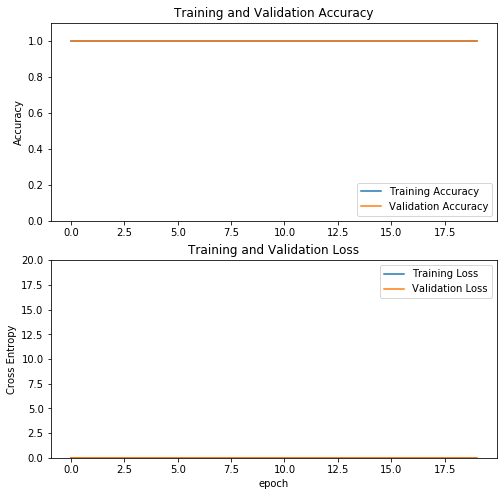

In [75]:
acc = history.history['accuracy']
val_acc = history.history['accuracy']

loss = history.history['loss']
val_loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,20])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Testing model

In [76]:
from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt

In [77]:
models = [model]

In [78]:
path_validation = 'data_' + str(img_size) + '/validation'
test_data = ImageClassifierDataLoader.from_folder(path_validation)

INFO:tensorflow:Load image with size: 642, num_label: 2, labels: banknotes, unknown.


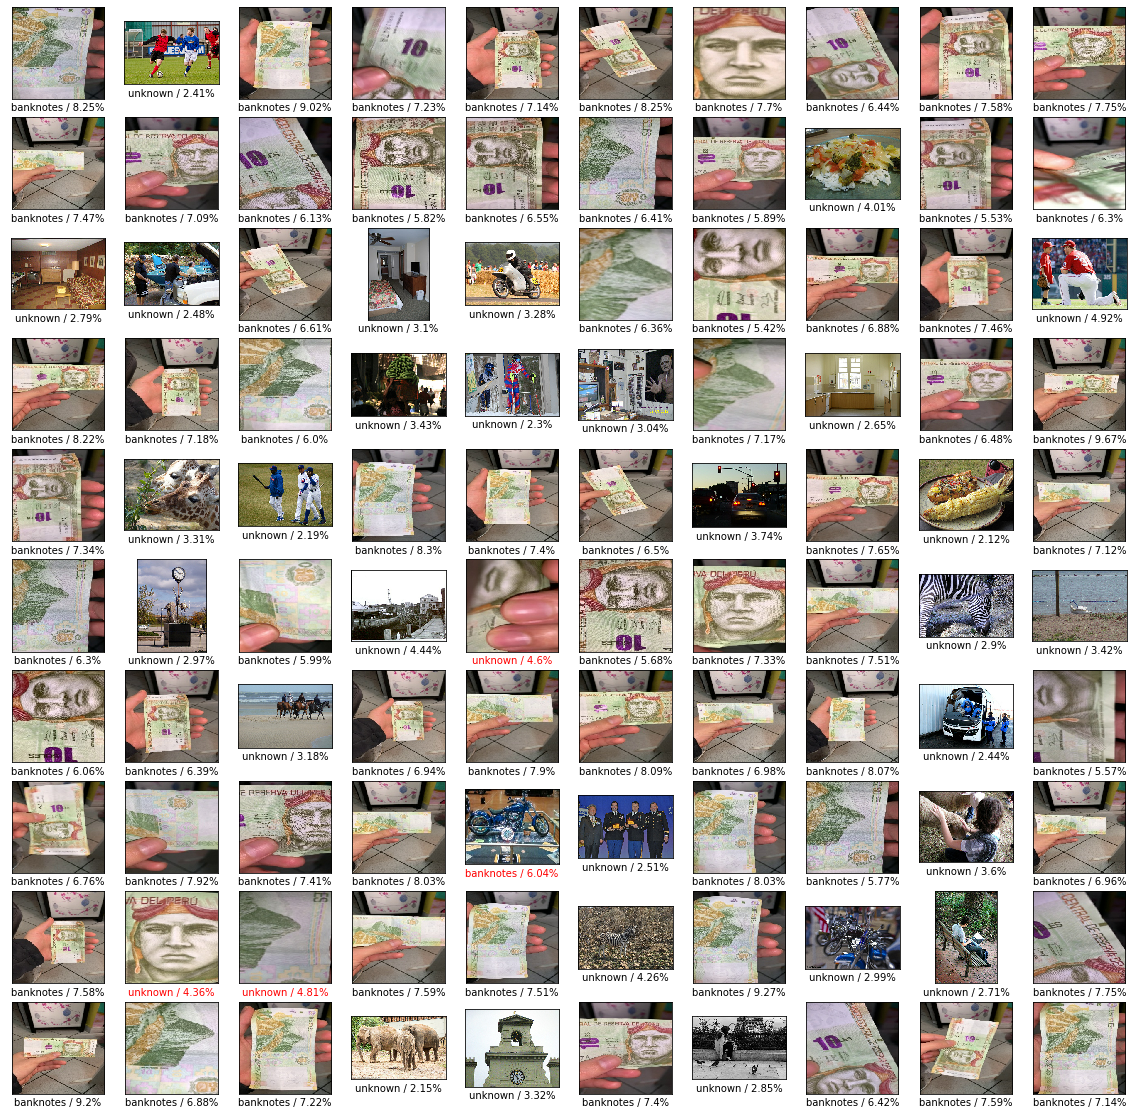

In [80]:
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    #predict
    '''
    image = imutils.resize(np.array(image), width=img_size, height=img_size)
    (fH, fW) = image.shape[:2]
    if fW < img_size or fH < img_size:
        continue
    '''
    
    image = img_to_array(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    
    #utilizando el average de los modelos para la predicción
    predictions = []
    for model in models:
        predictions.append(model.predict(image))
    
    prediction_average = np.average(predictions, axis=0)
    id_predict = np.argmax(prediction_average)
    percentage = round(prediction_average[0][id_predict], 2)
    #print(percentage)
    predict_label = 'banknotes'
    if percentage < 5.0:
        predict_label = 'unknown'
    
    #print(prediction_average * 100)
    #print(id_predict)
    #print('==============')
    
    #setup color
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    ax.xaxis.label.set_color(color)
    image_label = predict_label + ' / ' + str(percentage) + '%'
    plt.xlabel(image_label)
plt.show()